1. Importación de paquetes
Primero, importamos las bibliotecas necesarias para la simulación y el análisis de datos:

In [1]:
import h5py
import matplotlib.pyplot as plt
import meep as mp
import numpy as np
import os

Definimos funciones auxiliares para mostrar los campos e intensidades que genere la simulación. Esto nos evitará repetir código más adelante.

## Visualización de campos y geometría


In [2]:
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['figure.dpi'] = 300
# Mejora la resolución al mostrar figuras en pantalla
plt.rcParams['savefig.dpi'] = 300
# Mejora la resolución de las imágenes guardadas

plt.style.use('dark_background')

El colormap cmap_alpha crea un gradiente de color blanco que varía en transparencia, desde completamente transparente hasta completamente opaco. Esto se usa para mostrar la geometría del sistema (como las paredes y rendijas) sin bloquear la vista de los campos electromagnéticos simulados, permitiendo superponer ambos en una misma gráfica.

In [3]:
cmap_alpha = LinearSegmentedColormap.from_list(
    'custom_alpha', [[1, 1, 1, 0], [1, 1, 1, 1]])


este mapa de calor es el correspondiente al color del campo $E_z$

In [4]:
cmap_blue = LinearSegmentedColormap.from_list(
    'custom_blue', [[0, 0, 0], [0, 0.66, 1], [1, 1, 1]])

## Funciones


In [5]:
def label_plot(ax, title=None, xlabel=None, ylabel=None, elapsed=None):
    if title:
        ax.set_title(title)
    elif elapsed is not None:
        ax.set_title(f'{elapsed:0.1f} fs')
    if xlabel is not False:
        ax.set_xlabel('x (μm)'if xlabel is None else xlabel)
    if ylabel is not False:
        ax.set_ylabel('y (μm)'if ylabel is None else ylabel)

Esta función se encarga de etiquetar un gráfico con un título y nombres de ejes. Si se proporciona un título (title), lo muestra arriba de la gráfica; si no, y se entrega un valor de tiempo transcurrido (elapsed), se muestra ese tiempo en femtosegundos como título.

In [6]:
def plot_eps_data(eps_data, domain, ax=None, **kwargs):
    ax = ax or plt.gca()
    ax.imshow(eps_data.T, cmap=cmap_alpha, extent=domain, origin='lower')
    label_plot(ax, **kwargs)

Esta función grafica la geometría del dominio simulado, usando los valores de permitividad dieléctrica (eps_data). El parámetro domain especifica el área física del gráfico.

In [7]:
def plot_ez_data(ez_data, domain, ax=None, vmax=None, aspect=None, **kwargs):
    ax = ax or plt.gca()
    ax.imshow(
        np.abs(ez_data.T),
        interpolation='spline36',
        cmap=cmap_blue,
        extent=domain,
        vmax=vmax,
        aspect=aspect,
        origin='lower',
        )
    label_plot(ax, **kwargs)

Esta función muestra la intensidad del campo eléctrico simulado, específicamente el componente Ez. Para ello, toma los valores complejos del campo y grafica su magnitud (valor absoluto) usando un colormap azul personalizado (cmap_blue).

In [8]:
def plot_pml(pml_thickness, domain, ax=None):
    ax = ax or plt.gca()
    x_start = domain[0] + pml_thickness
    x_end = domain[1] - pml_thickness
    y_start = domain[2] + pml_thickness
    y_end = domain[3] - pml_thickness
    rect = plt.Rectangle(
        (x_start, y_start),
        x_end - x_start,
        y_end - y_start,
        fill=None,
        color='#fff',
        linestyle='dashed',
        )
    ax.add_patch(rect)

Esta función dibuja un rectángulo punteado que marca el borde interior del dominio de simulación, excluyendo las regiones absorbentes (PML). Calcula esta zona útil restando el grosor del PML a cada borde del dominio. Así, el rectángulo representa el área donde realmente ocurre la simulación

## Unidades en meep

Meep no trabaja con unidades físicas absolutas como metros o segundos, sino que utiliza unidades adimensionales basadas en la escala de las ecuaciones de Maxwell, que son invariantes bajo cambios de escala. En este caso, elegimos trabajar con micrómetros (μm) para longitud y femtosegundos (fs) para tiempo. Internamente, Meep define la velocidad de la luz como igual a 1, lo cual implica que 1 unidad de tiempo en Meep es el tiempo que la luz tarda en recorrer 1 unidad de distancia. Por ejemplo, si usamos micrómetros como unidad de distancia, entonces una unidad de tiempo en Meep equivale al tiempo que tarda la luz en recorrer 1 μm. Como la velocidad de la luz en el vacío es aproximadamente c = 299792458m/s= 0.3μm/fs

## Dominio y geometría

 En primer lugar, se establece el valor de la velocidad de la luz en unidades de micrómetros por femtosegundo (μm/fs), que es aproximadamente 0.2998. Esto permite convertir fácilmente entre unidades físicas y unidades naturales de Meep. Luego se define el dominio espacial bidimensional en el cual se llevará a cabo la simulación. Este dominio tiene un tamaño de 30 μm de ancho por 20 μm de alto, y se centra automáticamente usando el objeto mp.Vector3. También se crea una variable cell_size que representa las dimensiones del dominio como vector, algo que Meep requiere para inicializar el espacio de simulación.



In [9]:
SOL = 299792458e-9

# 2D spatial domain measured in μm
domain = [0, 30, -10, 10]
center = mp.Vector3(
    (domain[1] + domain[0]) / 2,
    (domain[3] + domain[2]) / 2,
    )
cell_size = mp.Vector3(
    domain[1] - domain[0],
    domain[3] - domain[2],
    )

Este segmento de código construye la geometría de una pared con doble rendija usando tres bloques verticales de material altamente dieléctrico, que bloquean la luz. Los dos bloques laterales forman los bordes de la pared, y el bloque central separa las dos aberturas. Además, se añaden capas PML alrededor del dominio para absorber las ondas en los bordes y evitar reflexiones, simulando un espacio abierto.



In [10]:
wall_position = 10
# Pared ubicada a 10 μm desde el borde izquierdo del dominio
wall_thickness = 0.5
# Grosor de la pared (bloques) en dirección x
aperture_width = 1
# Ancho de cada rendija (apertura) en dirección y
inner_wall_len = 4
# Altura del bloque central que separa las dos rendijas

Cálculo del tamaño de los bloques exteriores:

In [11]:
outer_wall_len = (
    cell_size[1]
    - 2*aperture_width
    - inner_wall_len
) / 2

material = mp.Medium(epsilon=1e6)  # Medio dieléctrico muy denso

Los tres bloques (mp.Block) están dispuestos verticalmente y ubicados con coordenadas centradas respecto al dominio de Meep (center.x se resta para centrar correctamente).

In [12]:
geometry = [
    mp.Block(
        mp.Vector3(wall_thickness, outer_wall_len, mp.inf),
        center=mp.Vector3(
            wall_position - center.x,
            domain[3] - outer_wall_len / 2),
        material=material),
    mp.Block(
        mp.Vector3(wall_thickness, outer_wall_len, mp.inf),
        center=mp.Vector3(
            wall_position - center.x,
            domain[2] + outer_wall_len / 2),
        material=material),
    mp.Block(
        mp.Vector3(wall_thickness, inner_wall_len, mp.inf),
        center=mp.Vector3(wall_position - center.x, 0),
        material=material),
    ]

Al final, se crea la capa PML que crea un recubrimiento alrededor del dominio que absorbe las ondas salientes sin reflexión.

In [13]:
pml_thickness = 1
pml_layers = [mp.PML(pml_thickness)]

-----------
Initializing structure...
time for choose_chunkdivision = 1.81198e-05 s
Working in 2D dimensions.
Computational cell is 30 x 20 x 0 with resolution 10
     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
time for set_epsilon = 0.088201 s
-----------


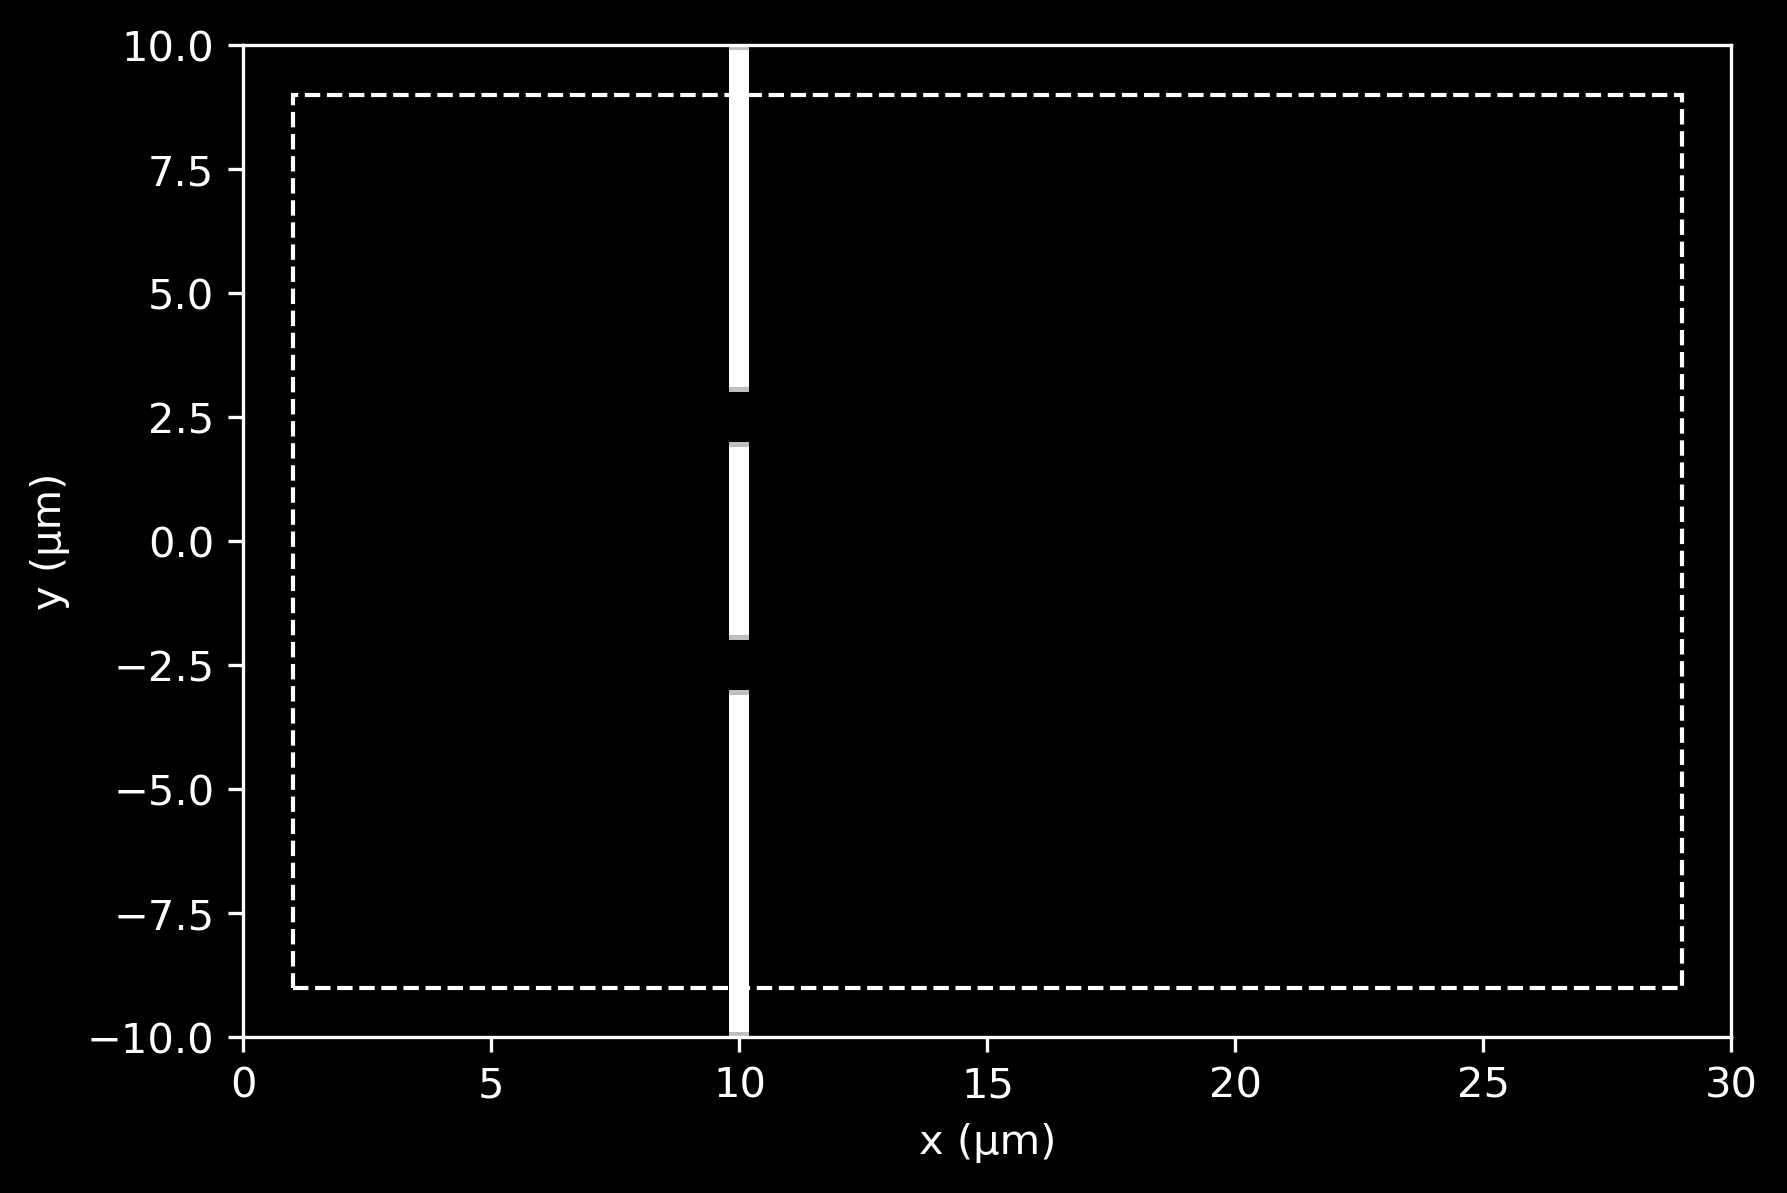

In [14]:
# Extract and visualize the dielectric data (wall geometry)
sim = mp.Simulation(cell_size=cell_size, geometry=geometry, resolution=10)
sim.init_sim()
eps_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Dielectric)
ax = plt.gca()
plot_pml(pml_thickness, domain, ax=ax)
plot_eps_data(eps_data, domain, ax=ax)

## Fuente de luz

En esta sección definimos una fuente de luz con características similares a un láser, utilizando una longitud de onda de 470 nanómetros (0.47 μm), correspondiente a luz azul visible. La frecuencia se calcula como el inverso de la longitud de onda, ya que en las unidades de Meep la velocidad de la luz es igual a 1. El haz tendrá un ancho de 6 μm, suficiente para cubrir ambas rendijas. La idea es simular un haz colimado, es decir, un haz cuyos rayos son paralelos y no se dispersan, lo cual es típico en un láser real. Sin embargo, Meep no ofrece directamente una fuente colimada, ya que $GaussianBeam2DSource$ requiere un punto focal, lo que implica divergencia. Para superar esta limitación, se define manualmente una función de amplitud que describe una onda plana compleja que se propaga en la dirección x, utilizando una exponencial compleja (np.exp). Esta estrategia permite construir un haz láser continuo, direccional y estacionario, ideal para estudiar la interferencia producida por la doble rendija.

In [15]:
source_lambda = 0.47  # in μm
source_frequency = 1 / source_lambda
source_beam_width = 6

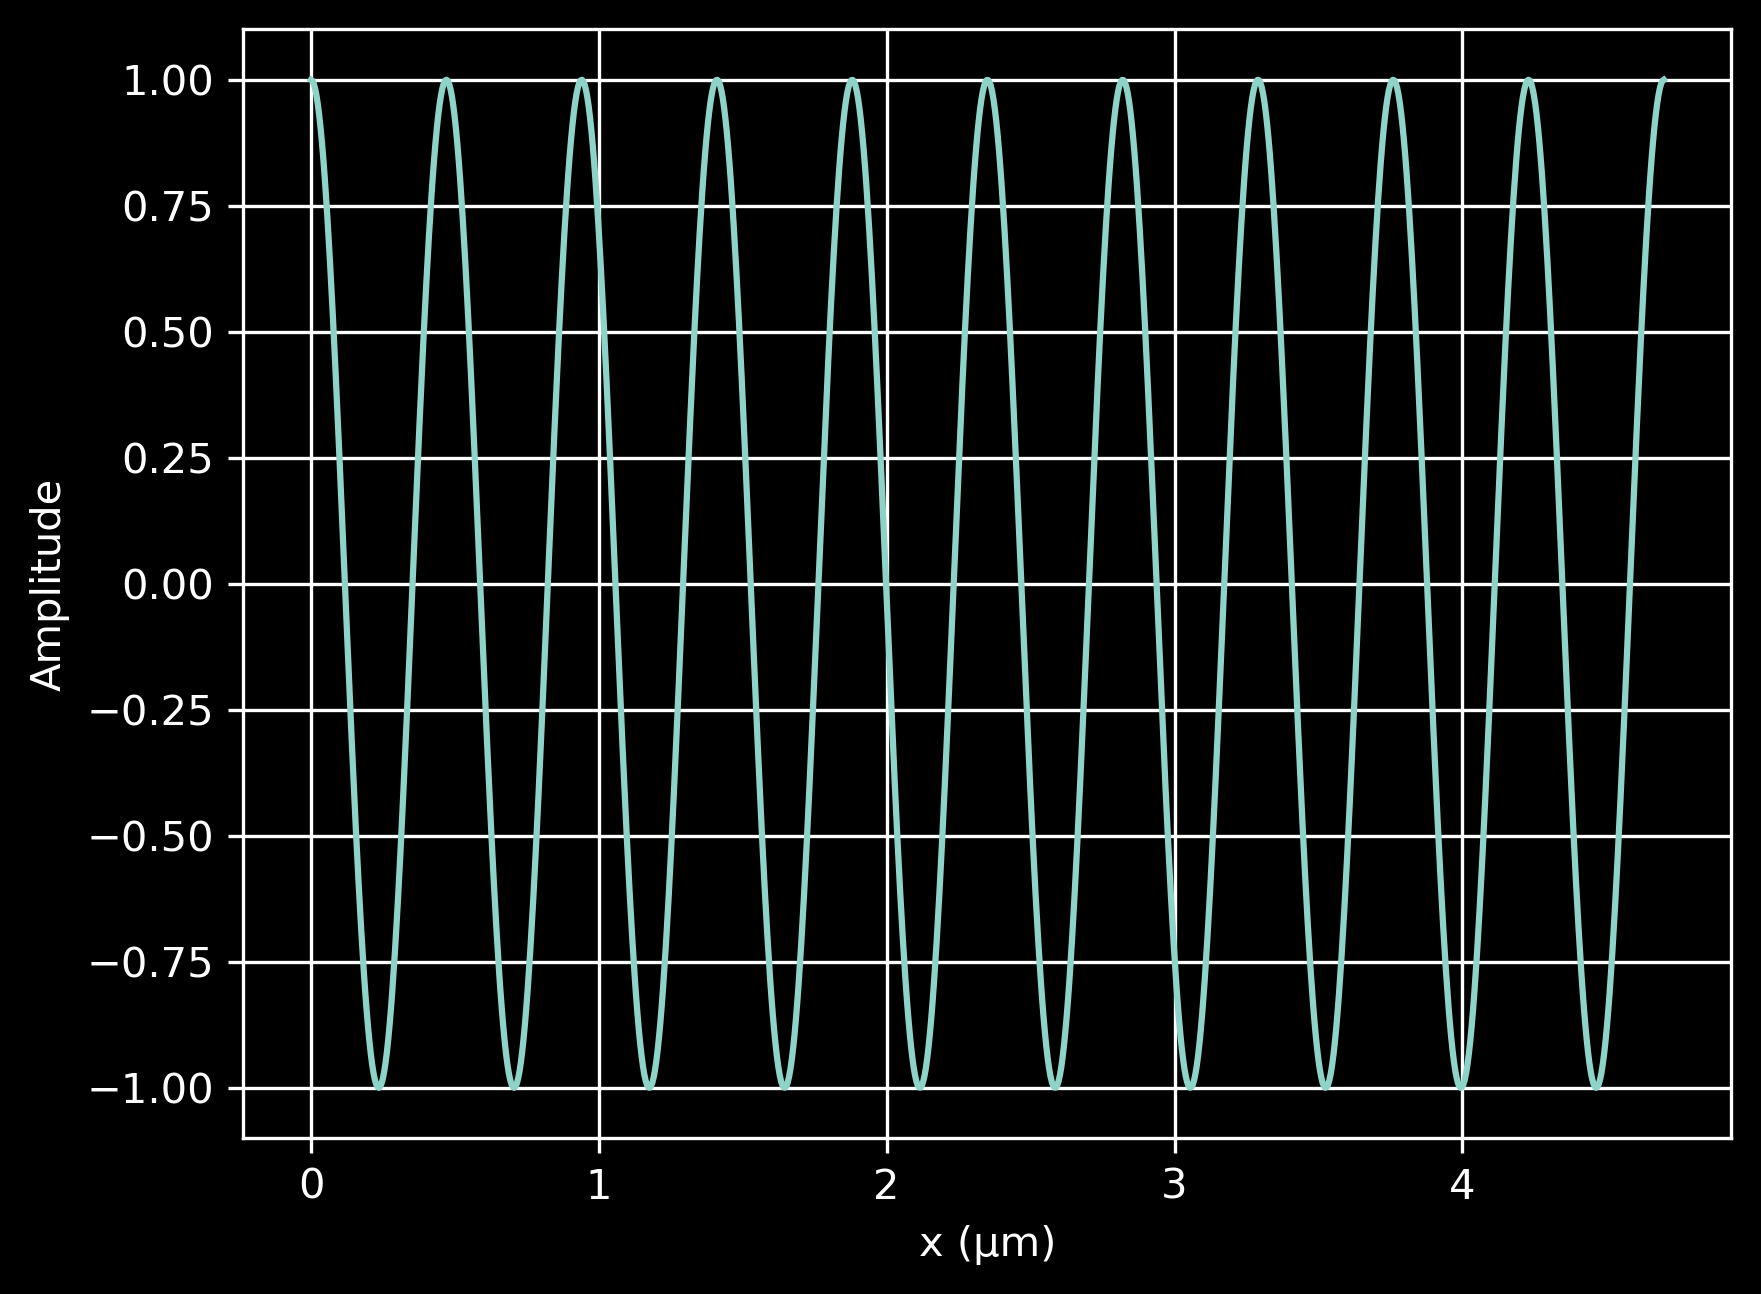

In [16]:
# A method to return a complex-valued plane wave in the x-direction
def plane_wave(x):
    return np.exp(2j * np.pi / source_lambda * x)

# Plot the plane wave
xarr = np.linspace(0, 10*source_lambda, 1000)
wave = plane_wave(xarr)
plt.plot(xarr, wave.real)
plt.xlabel('x (μm)')
plt.ylabel('Amplitude')
plt.grid(True)

Se define una segunda función que calcula el perfil gaussiano del haz a lo largo del eje y, que representa cómo varía la intensidad de la luz en dirección perpendicular a la propagación del haz. Este perfil tiene su valor máximo en el centro del haz (en y = 0) y disminuye simétricamente hacia los lados. La caída de la intensidad se describe con una distribución Gaussiana, cuya desviación estándar se toma como la mitad del ancho del haz (source_beam_width / 2), lo cual determina cuán concentrado o difuso es el haz. Esta función nos da una sección transversal del haz láser: cuando se grafica, muestra un pico en el centro y una disminución suave hacia los extremos, lo que refleja cómo la intensidad disminuye lejos del eje central. Combinando este perfil con la onda plana compleja de propagación, se obtiene una fuente personalizada que se comporta como un haz láser colimado, ideal para la simulación de interferencia en el experimento de doble rendija.

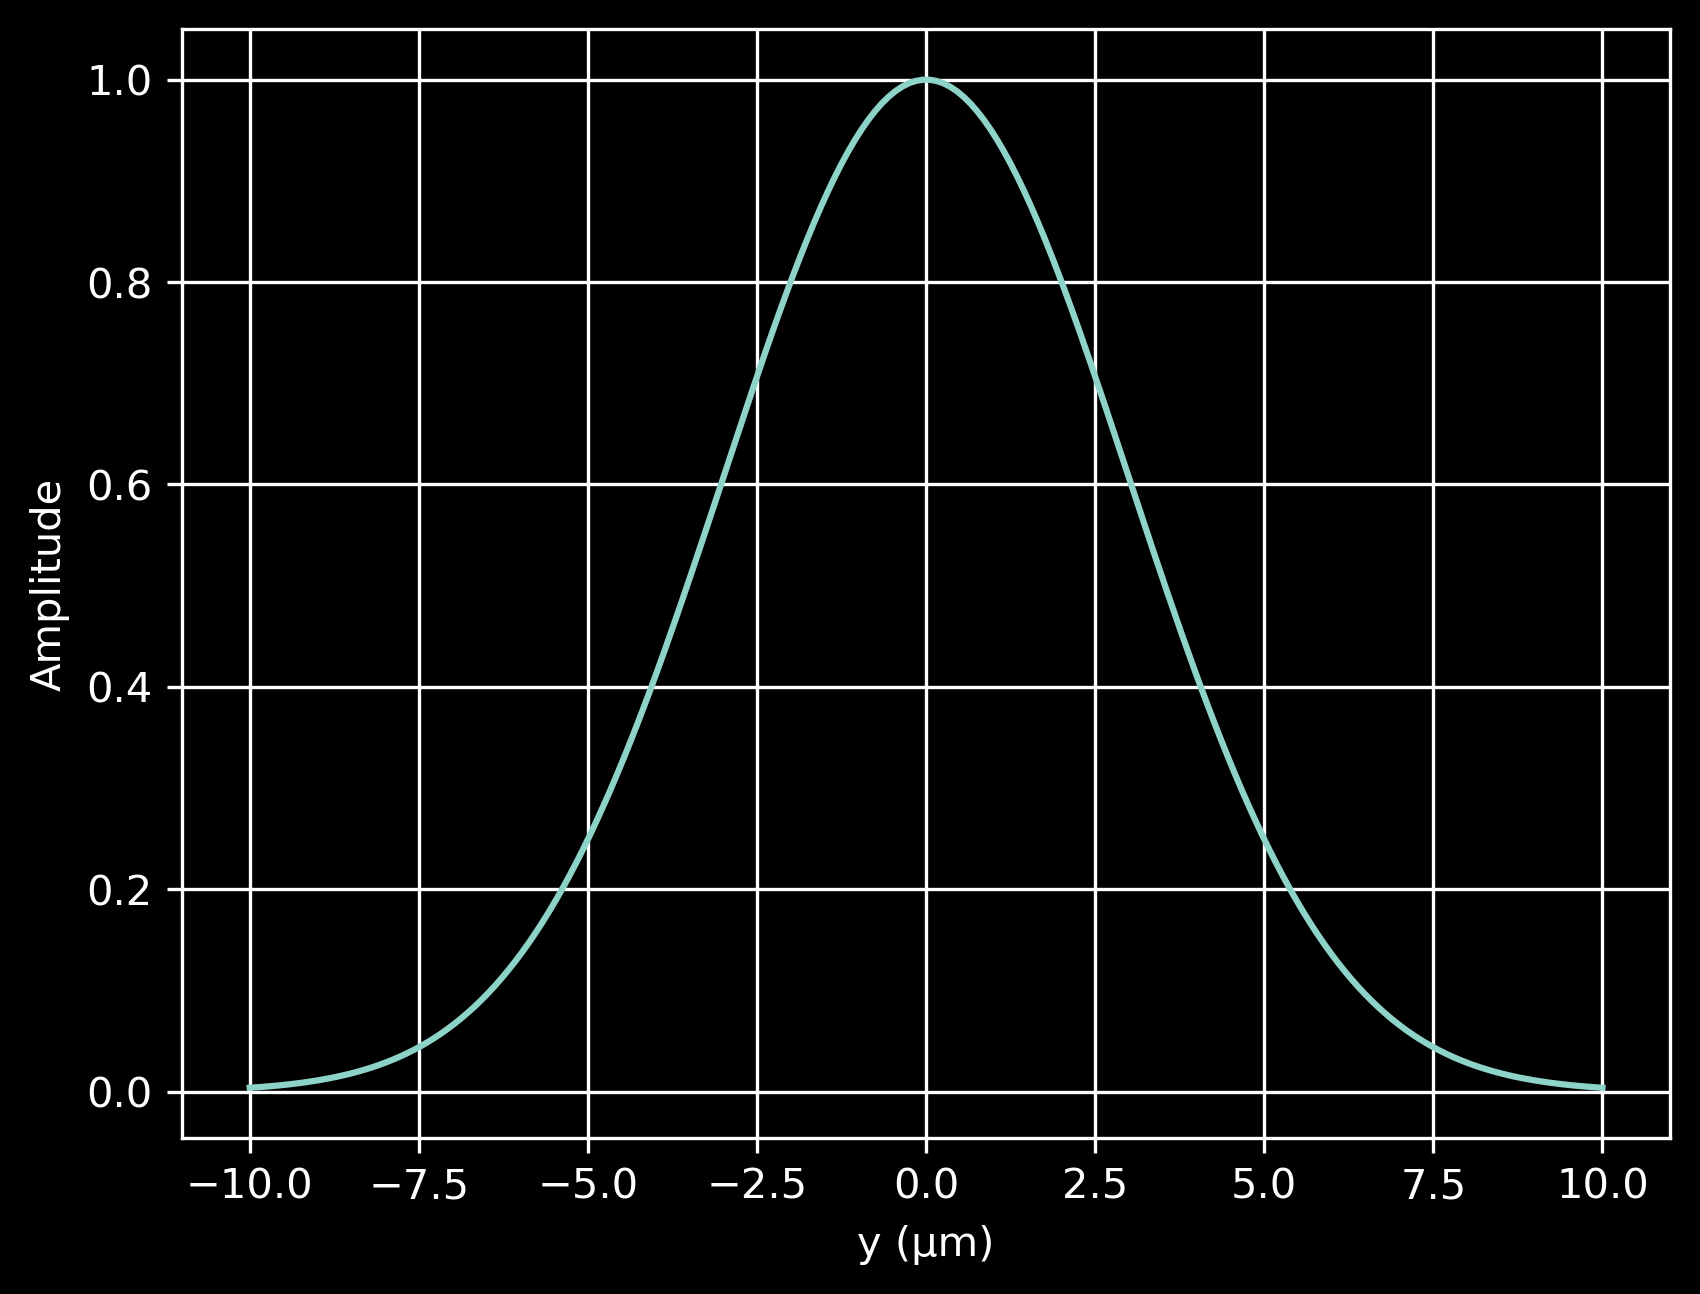

In [17]:
def gaussian_profile(y):
    return np.exp(-y**2 / (2 * (source_beam_width / 2)**2))

# Plot the Guassian profile
yarr = np.linspace(domain[2], domain[3], 200)
prof = gaussian_profile(yarr)
plt.plot(yarr, prof)
plt.xlabel('y (μm)')
plt.ylabel('Amplitude')
plt.grid(True)

Una vez definidas por separado la onda plana compleja (que representa la propagación del haz en dirección x) y el perfil gaussiano transversal (que modela la forma del haz en dirección y), se combinan multiplicándolas punto a punto sobre una malla 2D de coordenadas. Esta combinación da como resultado una función que describe la amplitud compleja total del haz láser en cada punto del plano. El producto entre ambas funciones genera un haz que viaja en la dirección x, con una distribución gaussiana en y, emulando un láser colimado. El resultado se grafica usando un mapa de colores (imshow), visualizando la parte real de la amplitud del campo eléctrico, lo cual muestra cómo se distribuye espacialmente la onda en el dominio de simulación.

Text(0, 0.5, 'y (μm)')

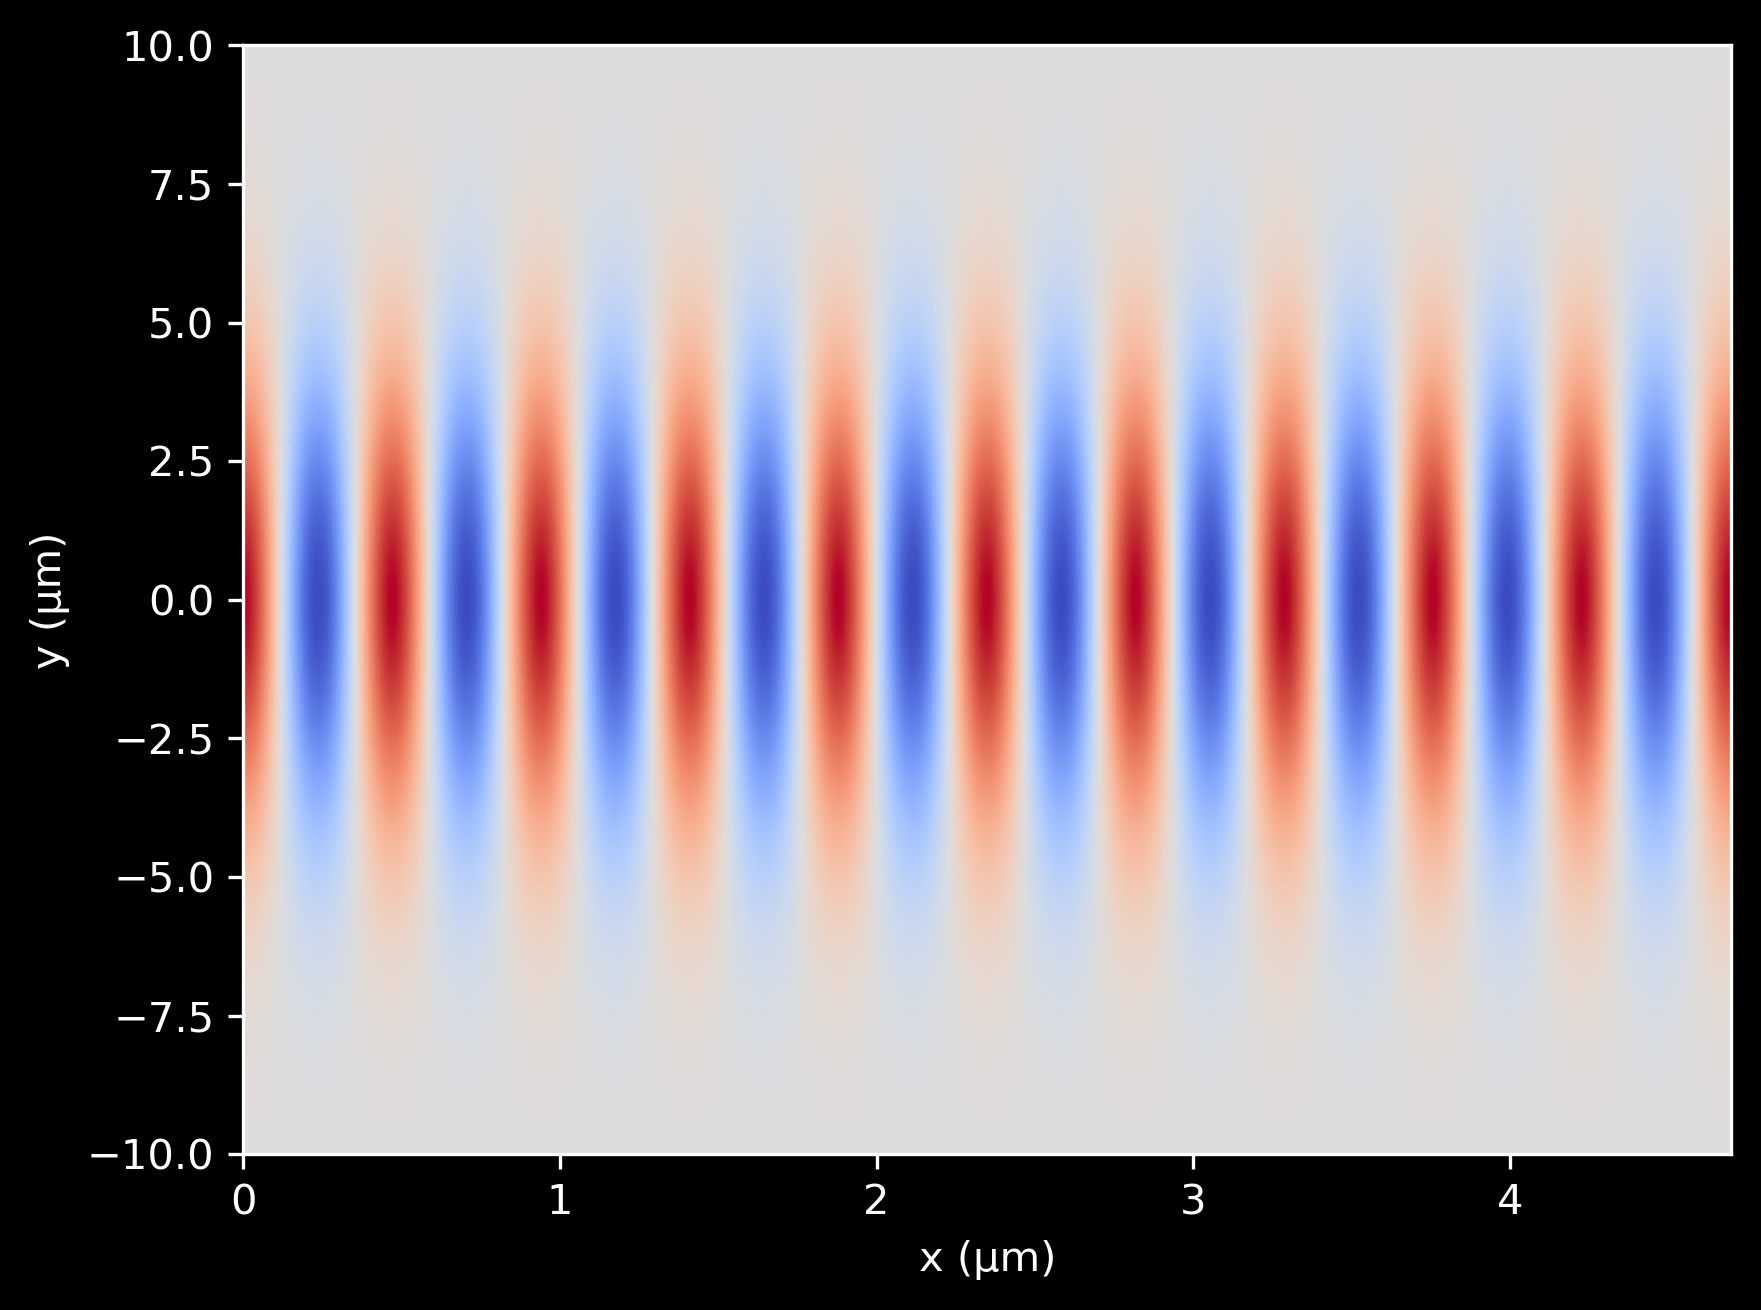

In [18]:
X, Y = np.meshgrid(xarr, yarr)

# Plot the combined terms
combined = plane_wave(X) * gaussian_profile(Y)
plt.imshow(
    np.real(combined),
    cmap='coolwarm',
    aspect='auto',
    extent=[xarr[0], xarr[-1], yarr[0], yarr[-1]],
    origin='lower',
    )
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')

Con la función combinada de onda plana y perfil gaussiano definida anteriormente, ahora se construye una fuente de luz en Meep usando el objeto mp.Source. Esta fuente es continua en el tiempo (ContinuousSource) y se configura con la frecuencia deseada, que determina qué tan rápido oscila el campo eléctrico. Se especifica que la fuente actúa sobre el componente Ez del campo, lo que indica una polarización perpendicular al plano de la simulación (modo TM en 2D).

In [19]:
def amp_func(pos):
    return plane_wave(pos[0]) * gaussian_profile(pos[1])

source = mp.Source(
    src=mp.ContinuousSource(
        frequency=source_frequency,
        is_integrated=True,
        ),
    component=mp.Ez,
    center= mp.Vector3(1, 0, 0) - center,  # positioned far-left, excluding PML
    size=mp.Vector3(y=cell_size[1]),       # span entire height, including PML
    amp_func=amp_func,
    )

La fuente se coloca sobre el borde izquierdo del dominio, justo antes del PML, y se extiende verticalmente a lo largo de toda la altura del dominio (incluyendo el PML). La clave está en el parámetro amp_func, al cual se le asigna la función combinada que define la distribución espacial del campo: una onda plana modulada por una envolvente gaussiana. Además, se utiliza is_integrated=True para que Meep maneje correctamente la parte de la fuente que entra en las regiones PML, evitando efectos no deseados en los bordes. Es importante notar que la frecuencia y la longitud de onda (source_lambda) se definen por separado: la frecuencia controla el comportamiento temporal de la fuente, mientras que la longitud de onda en amp_func determina su fase espacial inicial.

# Simulación

Finalmente, estamos listas para construir y ejecutar la simulación. El primer paso clave es definir una resolución adecuada, lo que significa establecer cuántos píxeles por micrómetro usará Meep para discretizar el dominio espacial.
En Meep, la resolución se especifica a través del parámetro resolution en la clase Simulation, y tiene un impacto directo tanto en la precisión de los resultados como en el costo computacional.

1. Longitud de onda de la luz:

La rejilla debe ser suficientemente fina para representar con precisión la onda.Una regla práctica es usar al menos 8 a 10 píxeles por la menor longitud de onda. Por ejemplo, si la luz tiene una longitud de onda mínima de 0.5 μm, una resolución entre 16 y 20 píxeles/μm es un buen punto de partida.

2. Tamaño de los detalles geométricos

Si la simulación incluye estructuras pequeñas o delgadas, se requiere una resolución alta para que Meep pueda representarlas correctamente. La resolución debe ser suficiente para capturar los detalles sin distorsión.

3. Recursos de simulación

A mayor resolución, mayor será el tiempo de simulación y el uso de memoria RAM.

4. Compromiso entre precisión y eficiencia

Comienza con una resolución moderada, ejecuta la simulación y analiza los resultados. Luego, incrementa la resolución y repite, si los resultados cambian mucho, la resolución inicial era insuficiente. Cuando los resultados se estabilizan (es decir, no cambian notablemente al aumentar la resolución), has encontrado una resolución adecuada.




In [20]:
smallest_length = min(
    source_lambda,
    wall_thickness,
    aperture_width,
    inner_wall_len,
)
pixel_count = 10
resolution = int(np.ceil(pixel_count / smallest_length))
print('Simulation resolution:', resolution)

Simulation resolution: 22


### Creación de la simulación

In [21]:
sim = mp.Simulation(
    cell_size=cell_size,
    # Tamaño del dominio simulado (Vector3)
    sources=[source],
    # Lista de fuentes de luz definidas previamente
    boundary_layers=pml_layers,
    # Capas PML para absorber las ondas en los bordes
    geometry=geometry,
    # Geometría de la doble rendija (los 3 bloques)
    resolution=resolution,
    # Resolución espacial (píxeles/μm)
    force_complex_fields=True,
    # Obliga a Meep a usar campos complejos (necesario para ver fase)
)

In [22]:
def get_data(sim, cell_size):
    ez_data = sim.get_array(
        center=mp.Vector3(), size=cell_size, component=mp.Ez)
    eps_data = sim.get_array(
        center=mp.Vector3(), size=cell_size, component=mp.Dielectric)
    return ez_data, eps_data

para ejecutar la simulación en meep

In [23]:
sim.run(until=cell_size[0] + 10)
ez_data, eps_data = get_data(sim, cell_size)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00031209 s
Working in 2D dimensions.
Computational cell is 30 x 20 x 0 with resolution 22
     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
time for set_epsilon = 0.428276 s
-----------
Meep: using complex fields.
Meep progress: 18.681818181818183/40.0 = 46.7% done in 4.0s, 4.6s to go
on time step 822 (time=18.6818), 0.00486969 s/step
Meep progress: 35.18181818181818/40.0 = 88.0% done in 8.0s, 1.1s to go
on time step 1548 (time=35.1818), 0.00550967 s/step
run 0 

 Después de ejecutar la simulación, se extraen los datos de campo eléctrico y geometría mediante la función get_data.

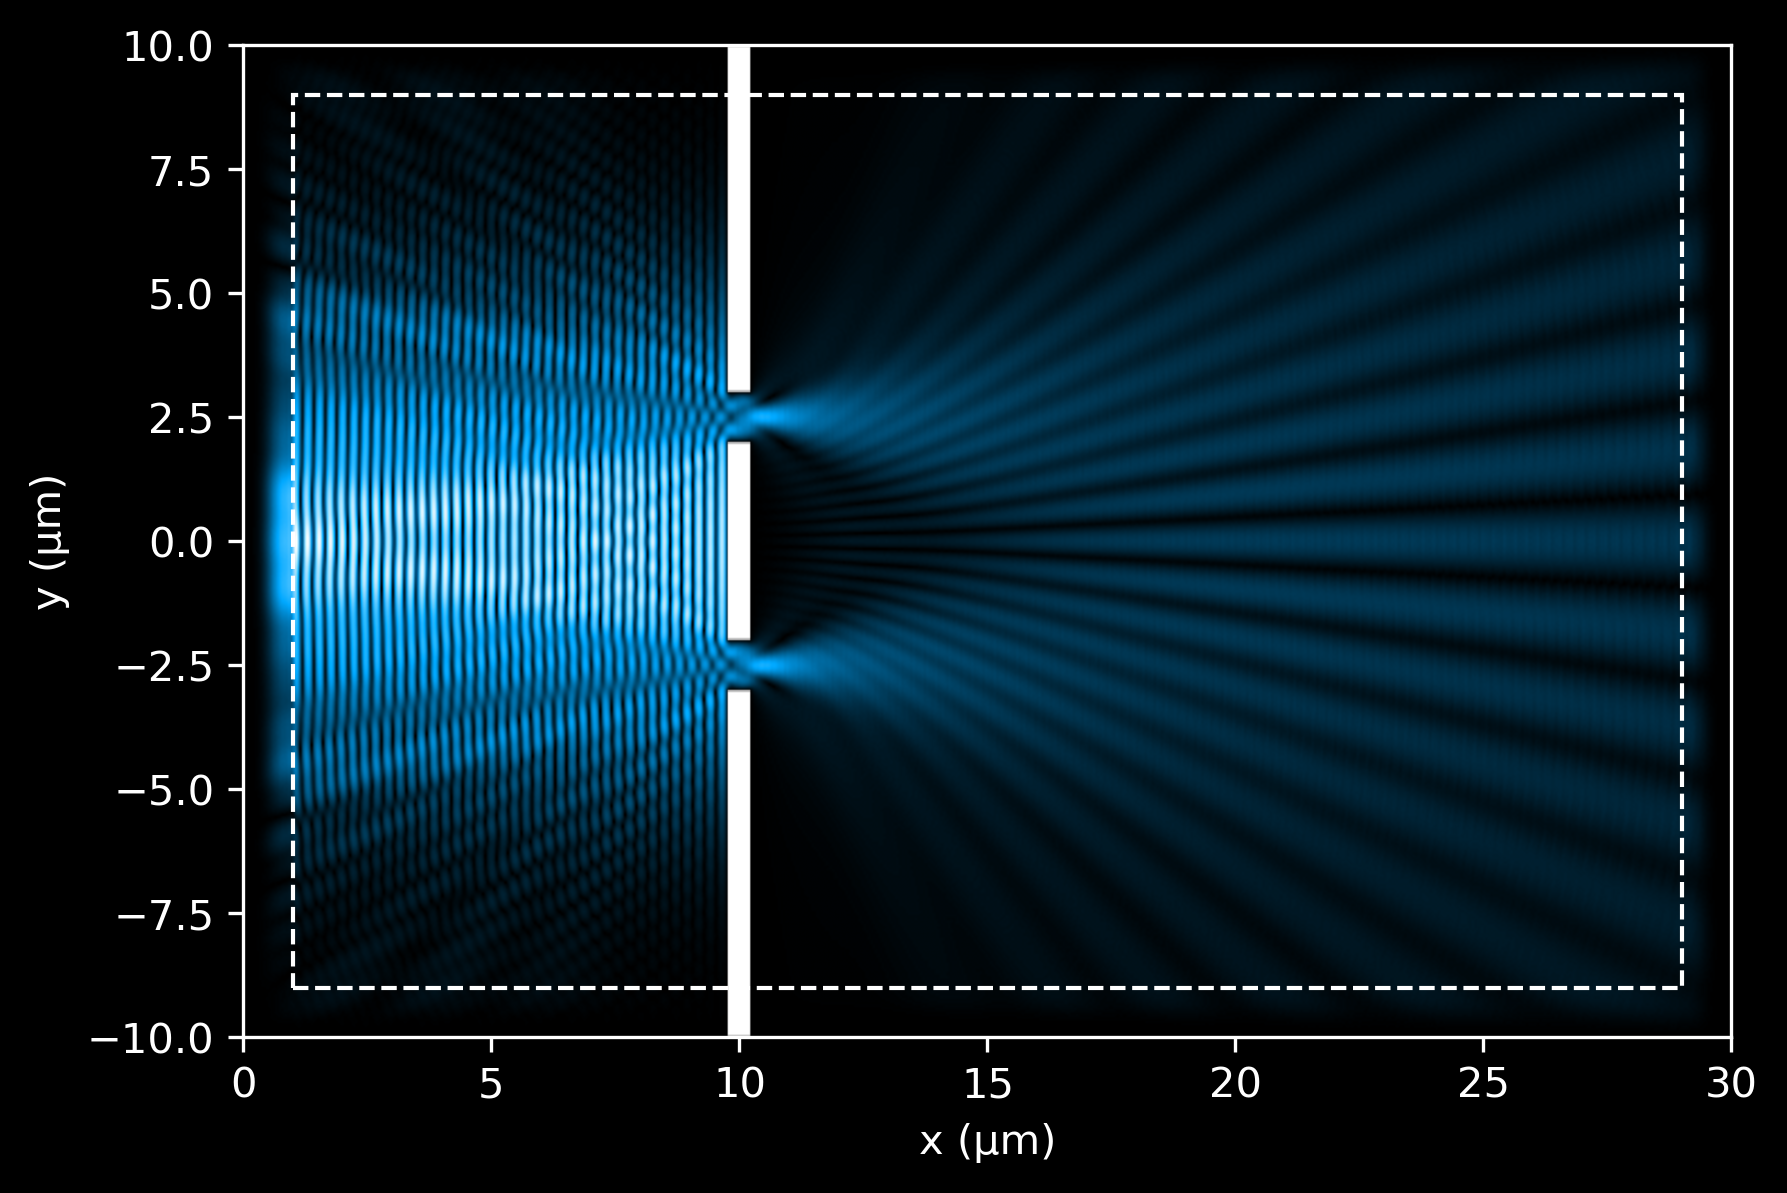

In [24]:
ax = plt.gca()
plot_ez_data(ez_data, domain, ax=ax)
plot_eps_data(eps_data, domain, ax=ax)
plot_pml(pml_thickness, domain, ax=ax)

En este bloque, organizamos una simulación temporal completa que se ejecuta durante un periodo definido (medido en femtosegundos, fs) y capturamos fotogramas periódicos del campo eléctrico a lo largo del tiempo. Esto nos permite observar de forma detallada cómo la luz se propaga a través del dominio simulado en Meep. Como Meep usa unidades propias, necesitamos convertir el tiempo físico (fs) a unidades Meep multiplicando por la velocidad de la luz (SOL, en μm/fs), para asegurar la coherencia con las unidades sin dimensión del framework.

La información generada en cada instante se guarda en un formato binario eficiente (usando h5py), lo que permite manejar grandes cantidades de datos sin comprometer el rendimiento. Para mantener el código limpio y reutilizable, se encapsula toda esta lógica en una función llamada simulate. Esta función se encarga de inicializar la simulación, recorrer los intervalos de tiempo deseados, capturar el campo eléctrico Ez en cada paso, y guardar cada fotograma en disco. De esta forma, podemos ejecutar toda la simulación de una sola vez, sin interrupciones, y registrar todo el proceso de propagación de la luz para su análisis posterior.

In [25]:
sim_time = 120  # in fs
n_frames = 6

# Where to save the results
sim_path = 'simulation.h5'

# Simulation object
sim = mp.Simulation(
    cell_size=cell_size,
    sources=[source],
    boundary_layers=pml_layers,
    geometry=geometry,
    resolution=resolution,
    force_complex_fields=True,
    )

def simulate(sim, sim_path, sim_time, n_frames):

    # Remove previous sim file, if any
    if os.path.exists(sim_path):
        os.remove(sim_path)

    # Time delta (in fs) between snapshots. Note that
    # we subtract 1 because we include the initial state
    # as the first frame.
    fs_delta = sim_time / (n_frames - 1)

    # Save data to an HDF5 binary file
    with h5py.File(sim_path, 'a') as f:

        # Save simulation params for future reference
        f.attrs['sim_time'] = sim_time
        f.attrs['n_frames'] = n_frames
        f.attrs['fs_delta'] = fs_delta
        f.attrs['resolution'] = sim.resolution

        # Save initial state as first frame
        sim.init_sim()
        ez_data, eps_data = get_data(sim, cell_size)
        f.create_dataset(
            'ez_data',
            shape=(n_frames, *ez_data.shape),
            dtype=ez_data.dtype,
            )
        f.create_dataset(
            'eps_data',
            shape=eps_data.shape,
            dtype=eps_data.dtype,
            )
        f['ez_data'][0]  = ez_data
        f['eps_data'][:] = eps_data

        # Simulate and capture remaining snapshots
        for i in range(1, n_frames):

            # Run until the next frame time
            sim.run(until=SOL * fs_delta)

            # Capture electral field data
            ez_data, _ = get_data(sim, cell_size)
            f['ez_data'][i]  = ez_data

simulate(sim, sim_path, sim_time, n_frames)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000331879 s
Working in 2D dimensions.
Computational cell is 30 x 20 x 0 with resolution 22
     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
time for set_epsilon = 0.427226 s
-----------
Meep: using complex fields.
run 0 finished at t = 7.204545454545455 (317 timesteps)
run 1 finished at t = 14.40909090909091 (634 timesteps)
on time step 783 (time=17.7955), 0.00511283 s/step
run 2 finished at t = 21.613636363636363 (951 timesteps)
run 3 finished at t = 28.818181

Cuando se complete la simulación, visualice las instantáneas una al lado de la otra.

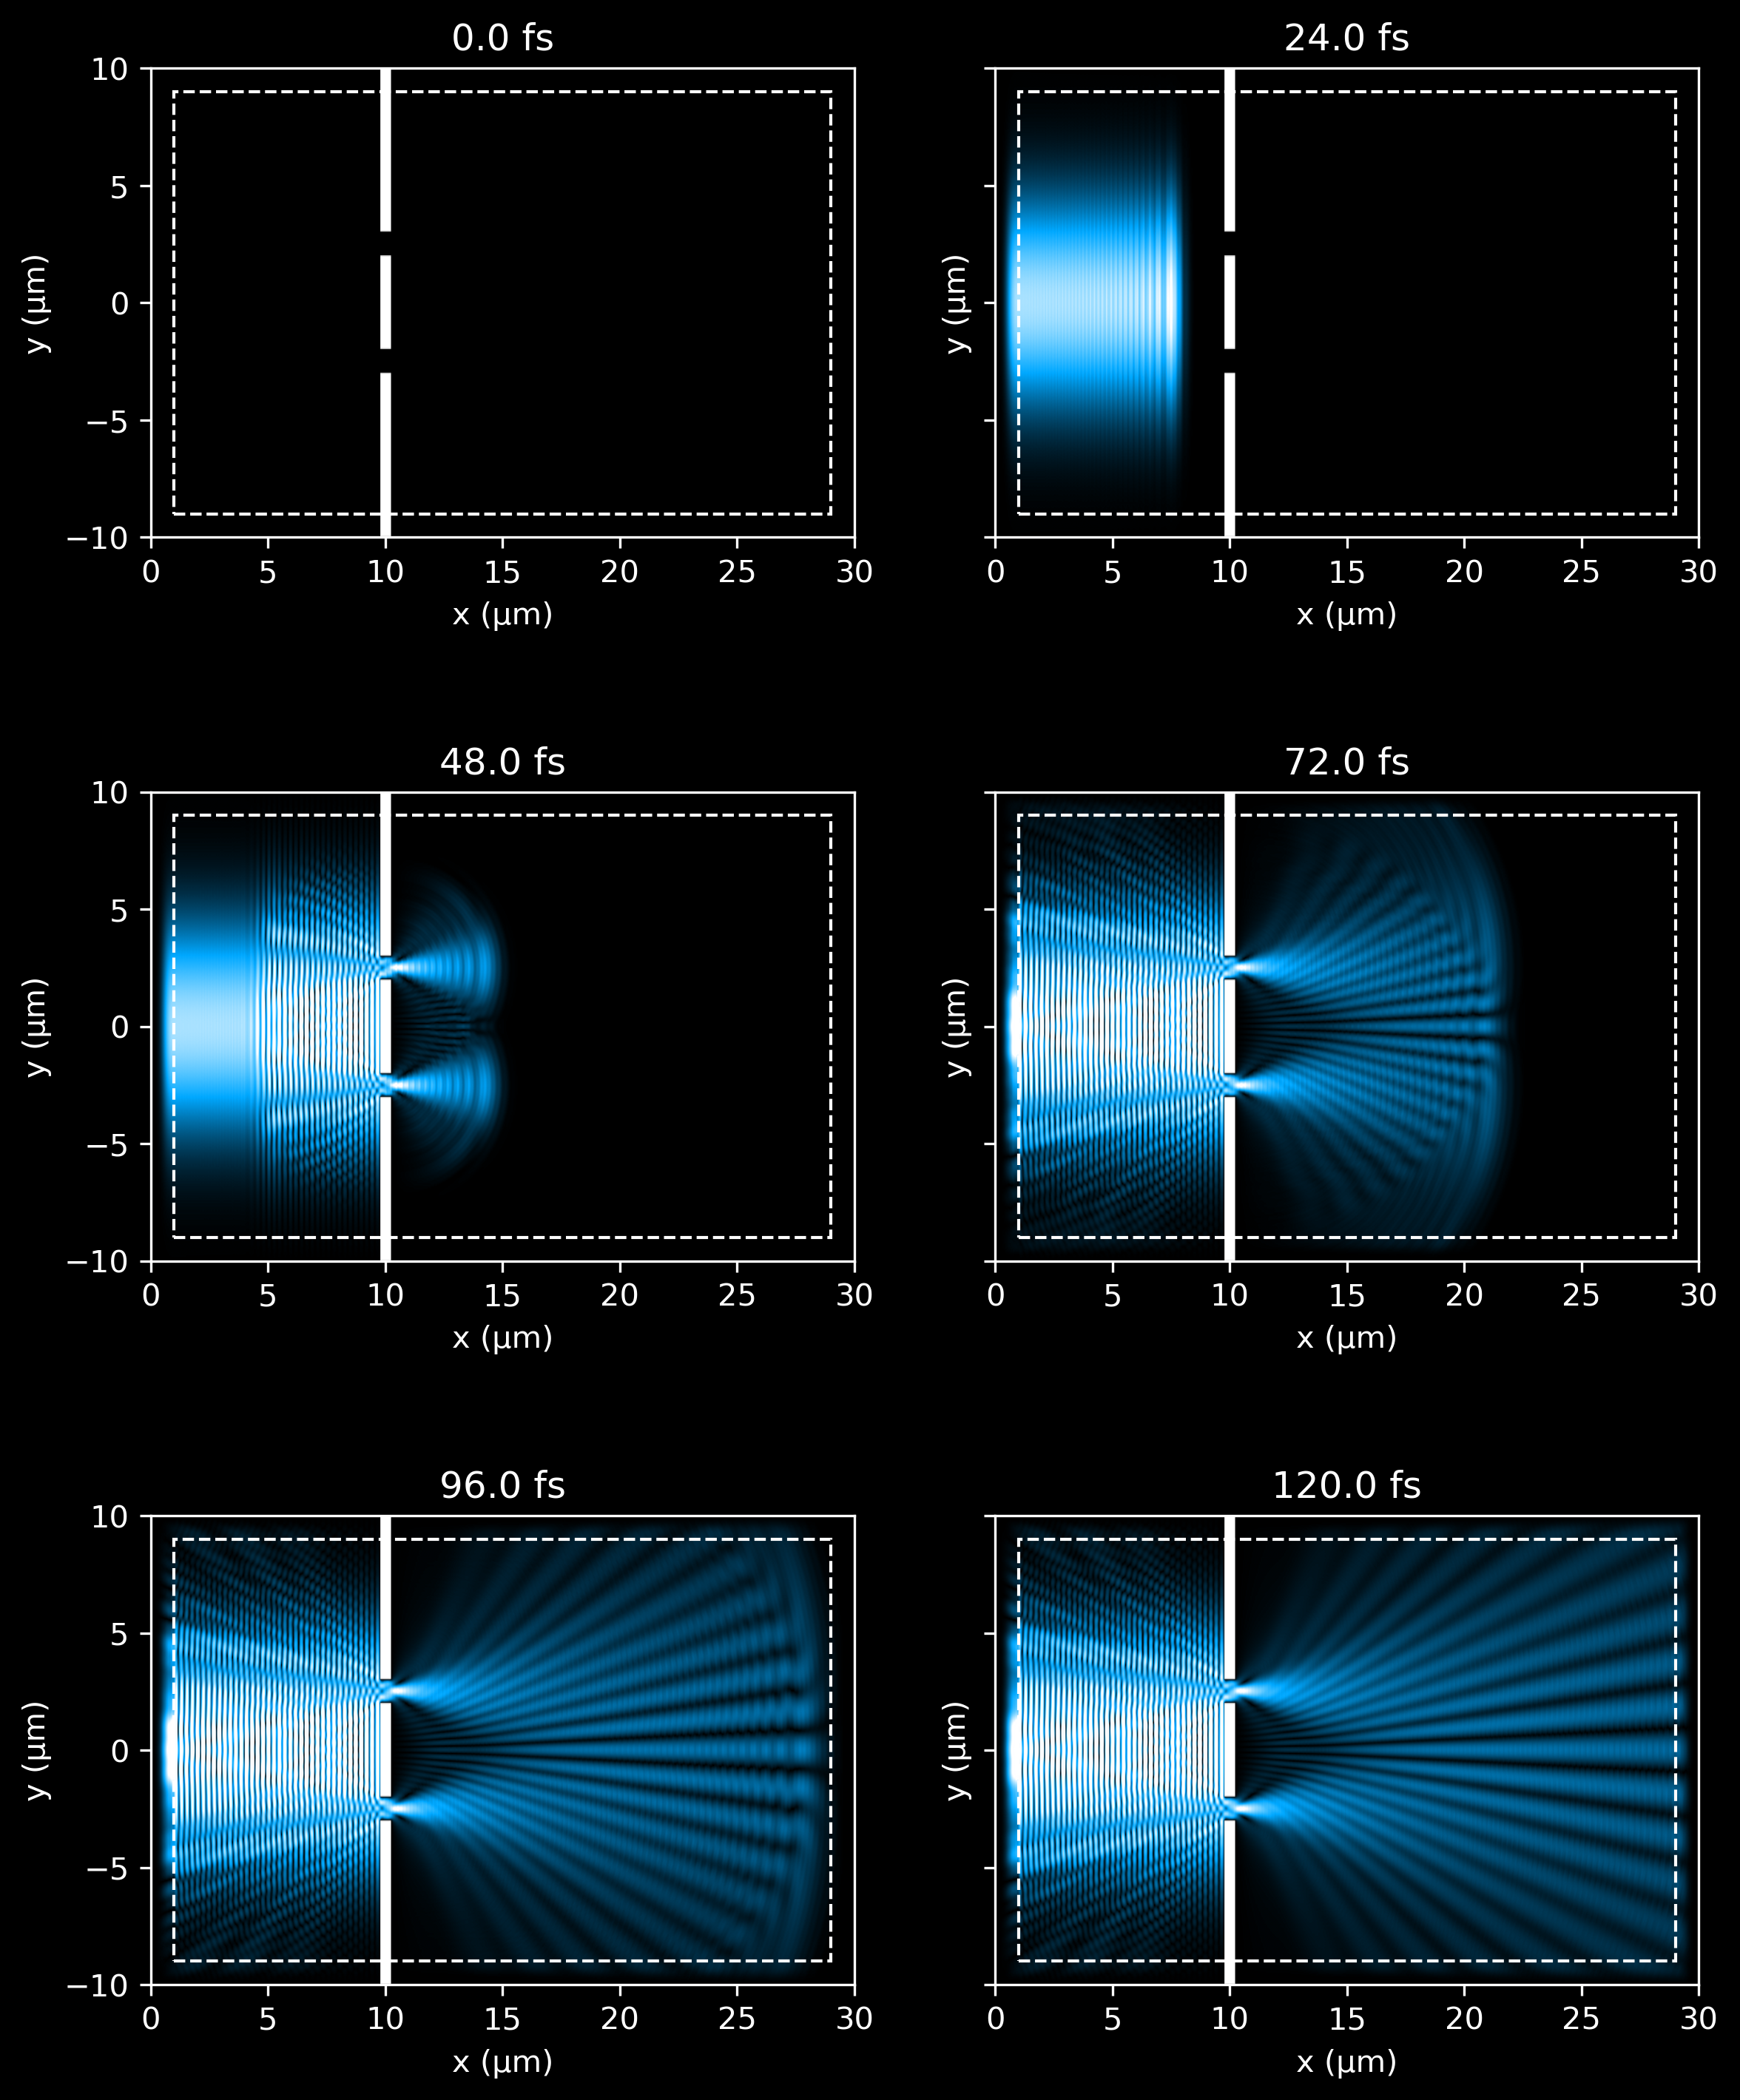

In [27]:
#the snapshots side-by-side.

fig_rows = 3
fig_cols = 2
n_subplots = fig_rows * fig_cols
fig, ax = plt.subplots(
    fig_rows,
    fig_cols,
    figsize=(9, 12),
    sharex=False,
    sharey=True,
    )

with h5py.File(sim_path, 'r') as f:
    for k in range(n_subplots):
        i, j = int(k / fig_cols), (k % fig_cols)
        # i, j = (k % fig_rows), int(k / fig_rows)
        _ax = ax[i][j]
        ez_data = f['ez_data'][k]
        eps_data = f['eps_data'][:]
        elapsed = k * f.attrs['fs_delta']
        vmax = 0.6  # force consistent brightness
        plot_ez_data(ez_data, domain, ax=_ax, vmax=vmax, elapsed=elapsed)
        plot_eps_data(eps_data, domain, ax=_ax)
        plot_pml(pml_thickness, domain, ax=_ax)

## Visualización de patrones de interferencia

nos centramos en visualizar el patrón de interferencia generado cuando la luz atraviesa las dos rendijas. Al observar cómo este patrón se forma y evoluciona conforme la luz se propaga más allá de la barrera, podemos comprender mejor el fenómeno de interferencia que surge por la superposición de ondas. Es importante recordar que la intensidad de la luz es proporcional al cuadrado de la amplitud del campo eléctrico, por lo que esta magnitud es la que se utiliza para representar la distribución de energía luminosa.

Para ello, se utiliza el último fotograma obtenido de la simulación, ya que representa el estado más "maduro" del sistema, cuando la luz ha tenido tiempo suficiente para desarrollarse completamente y las ondulaciones residuales son mínimas. A partir de este fotograma, se seleccionan varias secciones transversales (slices) a lo largo del eje x, justo después de las rendijas, para calcular y graficar la intensidad en cada una. Estas secciones permiten ver cómo varía el patrón de interferencia a distintas distancias, revelando los clásicos máximos y mínimos de intensidad causados por la interferencia constructiva y destructiva entre las dos ondas emergentes.

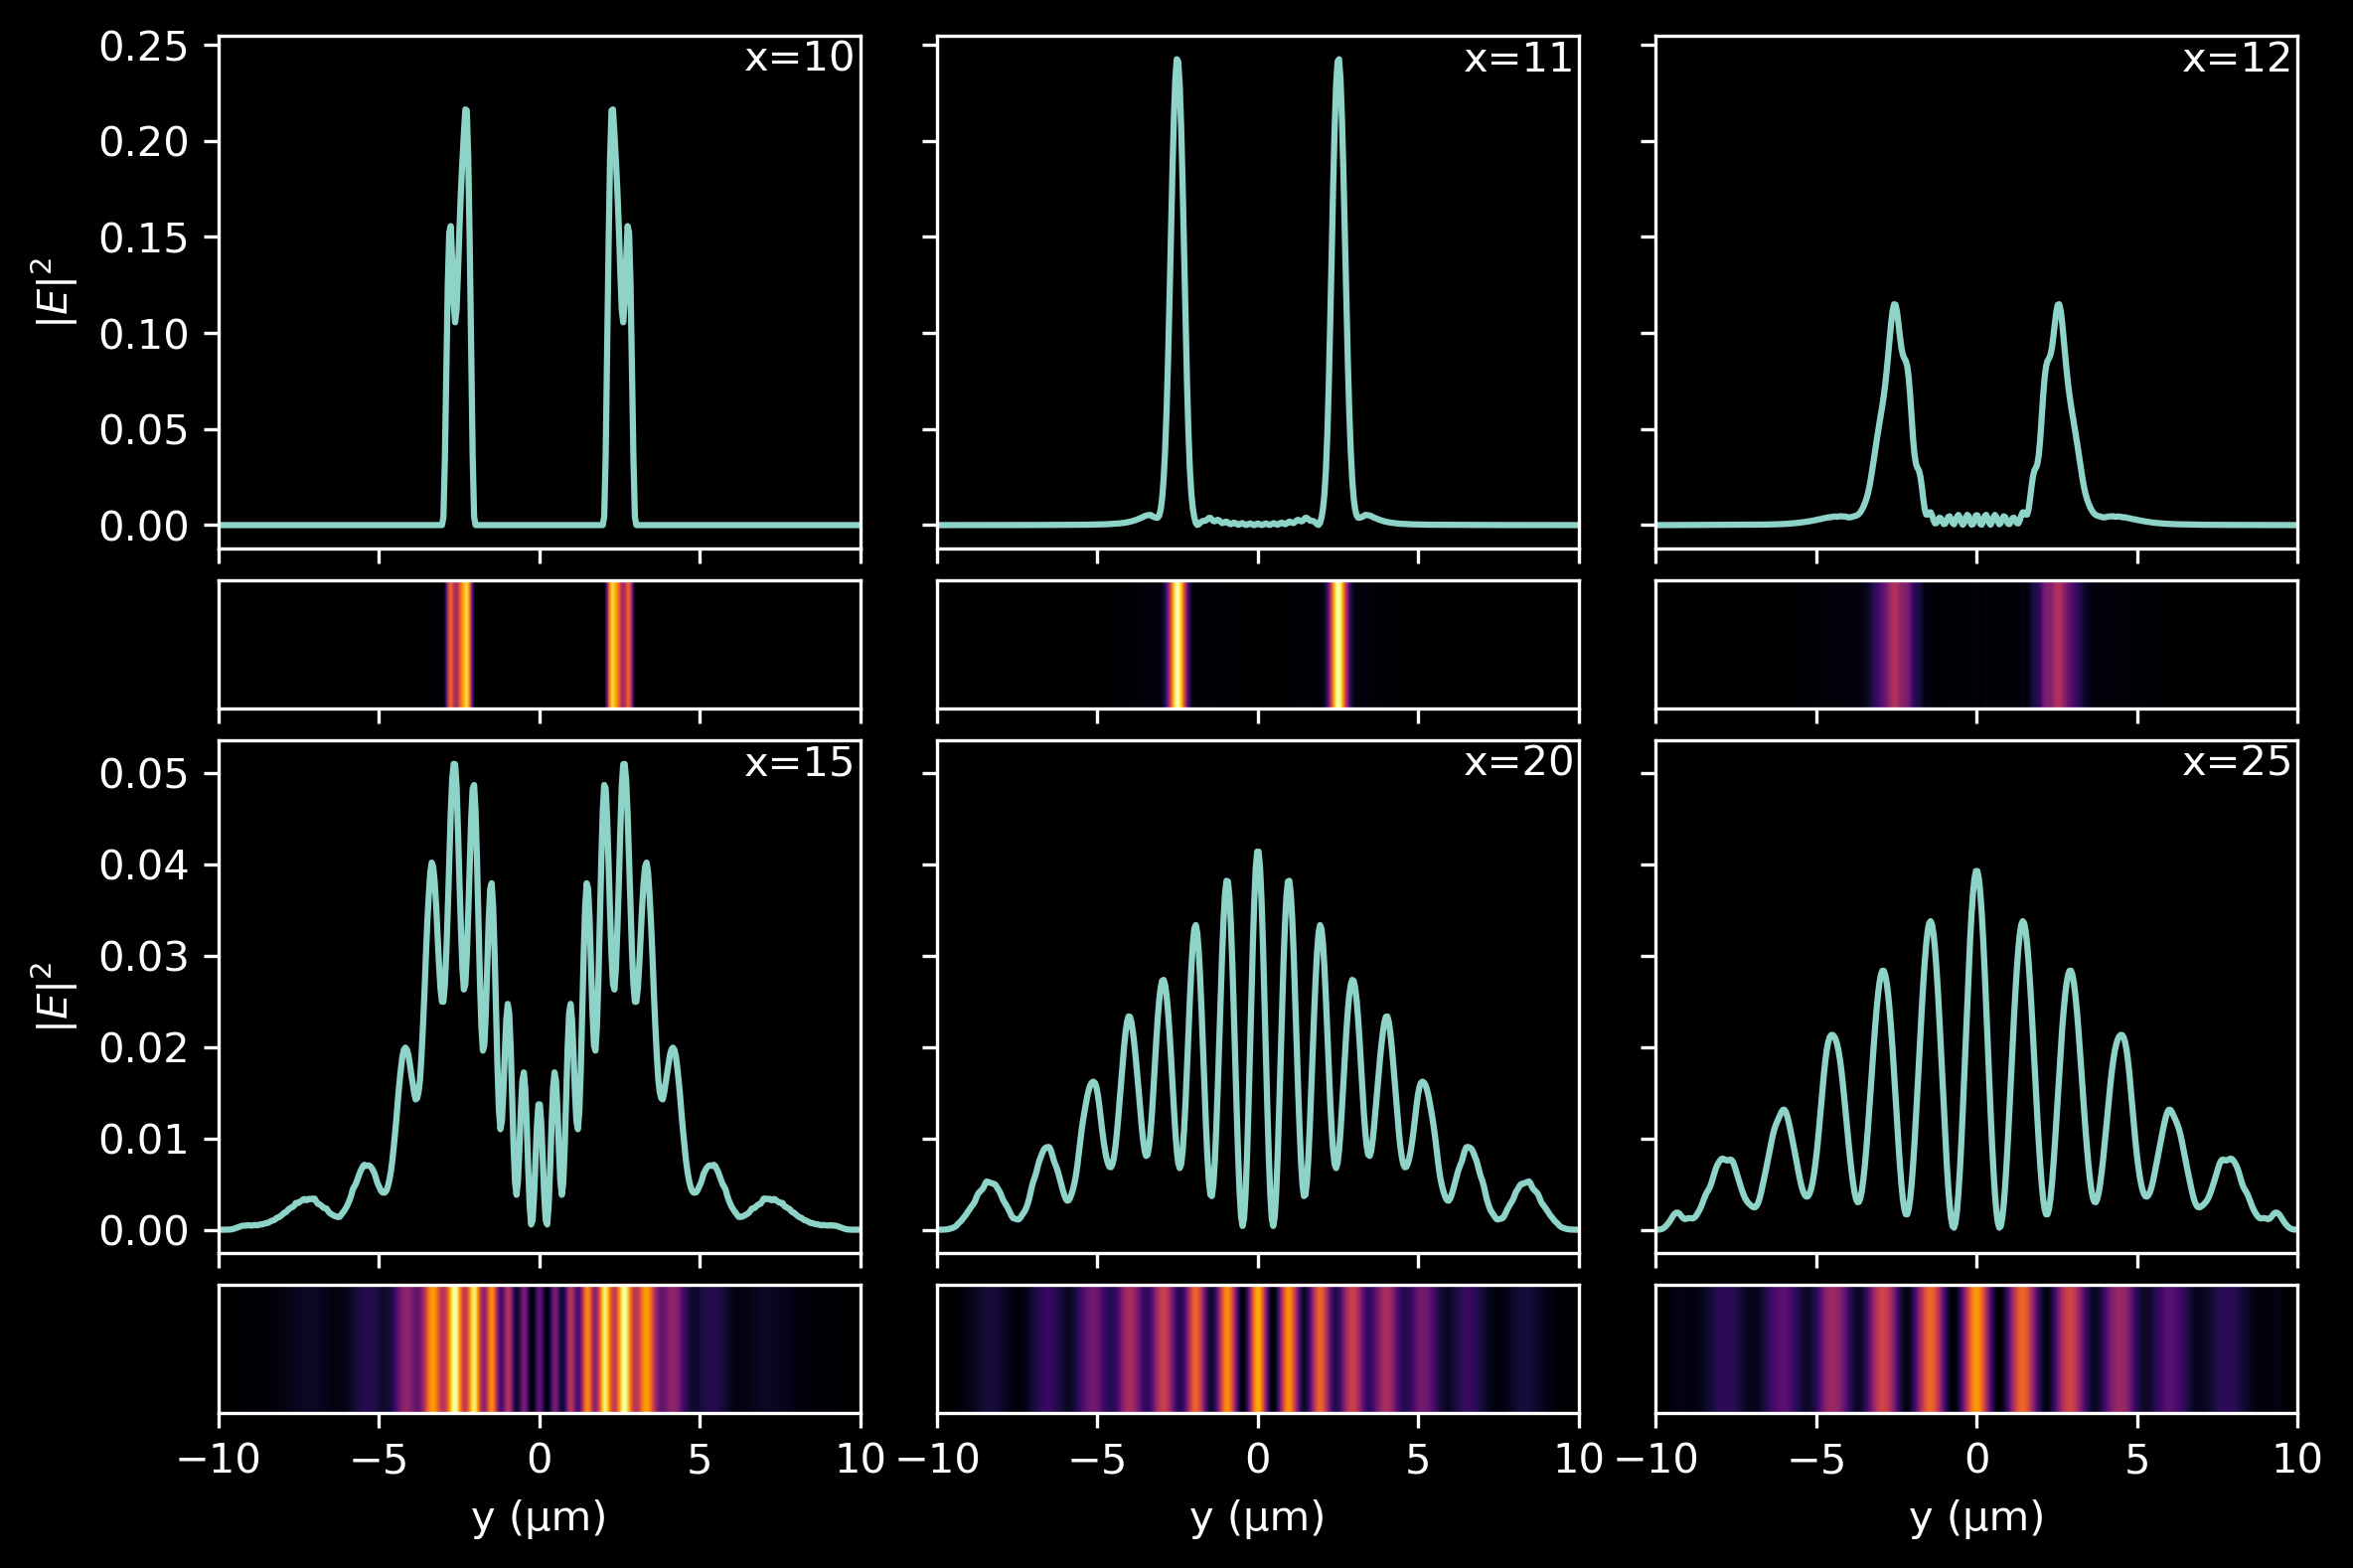

In [28]:
# Grab final simulation snapshot without time-averaging
with h5py.File(sim_path, 'r') as f:
    final_snap = f['ez_data'][-1]

# Compute intensity as square of the complex amplitude
final_snap = np.abs(final_snap)**2

# Pick slices at different distances from the double slit
slice_dists = [10, 11, 12, 15, 20, 25]
slices = [final_snap[i * resolution] for i in slice_dists]
yarr = np.linspace(domain[2], domain[3], final_snap.shape[1])

# A rather involved plotting function
def plot_intensity(slice, yarr, ax1, ax2, vmax=None, xval=None, xlabel=False, ylabel=False):
    ax1.plot(yarr, slice)
    ax1.tick_params(axis='x', labelbottom=False)
    if ylabel:
        ax1.set_ylabel('$|E|^2$')
    else:
        ax1.tick_params('y', labelleft=False)
    if xval:
        ax1.annotate(
            f'x={xval}',
            xy=(1, 1),
            xytext=(-4, -4),
            xycoords='axes fraction',
            textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='top',
            )
    ax2.imshow(
        np.vstack(slice).T,
        cmap='inferno',
        aspect='auto',
        vmax=vmax,
        extent=[yarr[0], yarr[-1], 0, 1],
        )
    ax2.set_xlim([yarr[0], yarr[-1]])
    ax2.tick_params('y', labelleft=False)
    ax2.set_yticks([])
    if xlabel:
        ax2.set_xlabel('y (μm)')
    else:
        ax2.tick_params(axis='x', labelbottom=False)

fig, ax = plt.subplots(
    4, 3,
    figsize=(9, 6),
    gridspec_kw=dict(
        width_ratios=(4, 4, 4),
        height_ratios=(4, 1, 4, 1),
        wspace=0.12,
        hspace=0.1,
        ),
    sharex='col',
    sharey='row',
    )
for k, slice in enumerate(slices):
    i = 2 * int(k / 3)
    j = k % 3
    plot_intensity(
        slice, yarr, ax[i][j], ax[i+1][j],
        vmax=np.max(slices[:3]) if k < 3 else np.max(slices[3:]),
        xval=slice_dists[k],
        xlabel=(i==2),
        ylabel=(j==0))